# Speed Calculation
The data set for this notebook was captured with a Garmin bike computer during the Great Dublin Bike Ride in September 2015.  The data file contains over 5,000 data points relating to about 5 hours of activity.

This notebook calculates the cyclists speed - which involves transforming the data source into a Panda time series and smoothing the data using a rolling average algorithm.

This data discovery shows that data smoothing of the speed data is required.  In turn data smoothing requires the data soruce to be transformed into a regular time frequency of one second.

This makes providing an accurate representation of a user's speed a more challenging activity than you would expect.

## Setups

In [1]:
#Import Python Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
# Define name and path of data file
# This data file contains a sub-set of activiy information relating to speed and time

input_file = 'activity_speed.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )

input_file_path = os.path.join(input_dir , input_file)

print ("Input file is (full path)  ", input_file_path)

Input file is (full path)   /opt/jupyter/data/csv/activity_speed.csv


In [3]:
# Load data file into a Pandas data frame for inspection
# The dataframe is indexed on time - time variant data
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)
# rename the speed column to speed_raw
df.rename( columns = {"speed":"speed_raw"} , inplace=True)
#check column names
df.columns

Index(['distance_diff', 'time_diff', 'speed_raw', 'moving', 'breaks'], dtype='object')

## Exploring the Imported Data Set

The fitness data consists of a set of data points whose values vary in time.
The data is a sequence in time order.

Each data point relates to a different point in time and contains the following variables:
* distince_diff - the distance travelled since the last data point
* time_diff - the number of seconds that have elapsed since the last data point
* speed_raw - measured in km/hr, calculated using formula (distance_diff / time_diff) * 3.6
* moving - if the data point represents movement then True.  If the user is at rest then False
* breaks - Set to True if the using is at rest and taking a break from activity

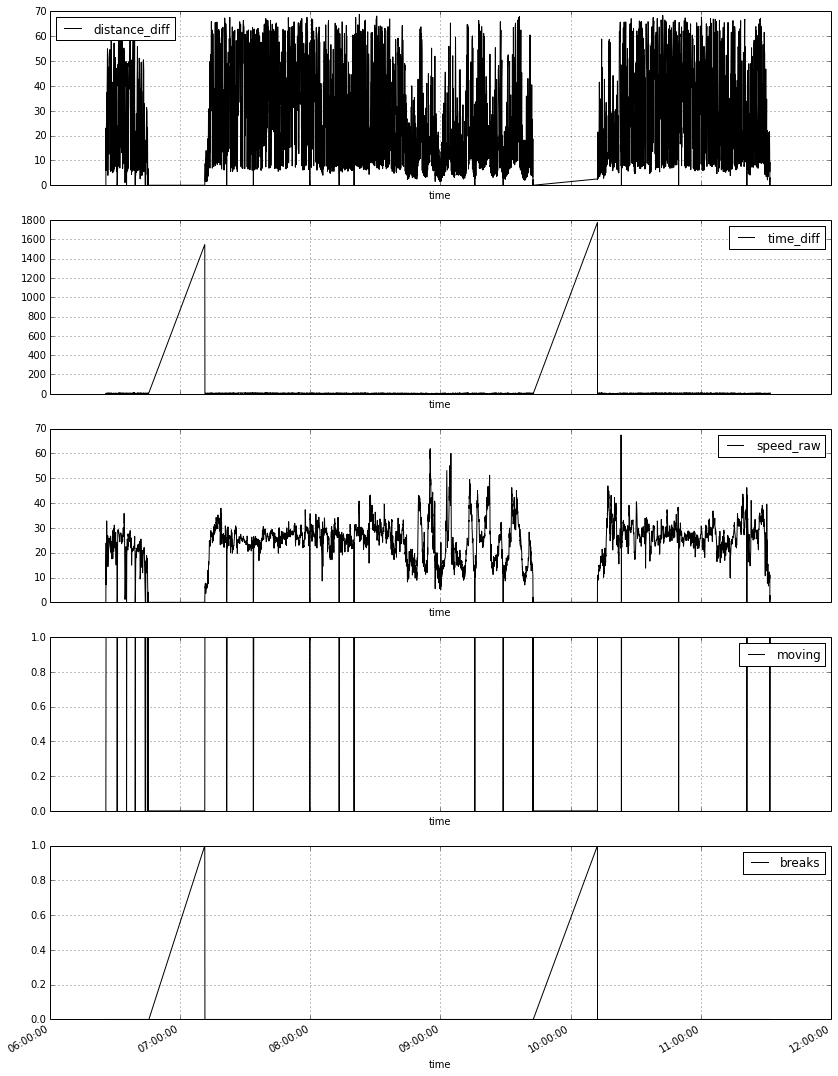

In [4]:
#plot all columns
_ = df.plot(subplots=True, 
        figsize=(14, 20),
         xlim=(datetime(2015,9,13,6,0,0),datetime(2015,9,13,12,0,0 )),
        )


In [5]:
# get statistical summary
df.describe()

,distance_diff,time_diff,speed_raw,moving,breaks
count,5358.000000,5358.000000,5358.000000,5358,5358
mean,19.660904,3.428891,25.820063,0.9925345,0.0003732736
std,18.063191,32.195810,9.102339,0.08608787,0.01931849
min,0.000000,1.000000,0.000000,False,False
25%,6.931396,1.000000,20.300000,1,0
50%,11.113281,1.000000,25.900000,1,0
75%,28.084473,4.000000,30.800000,1,0
max,68.839844,1775.000000,67.400000,True,True


## Exploring the Time Interval between Data Points

Inspection of the first few rows shows that the data is time indexed.   
The time_diff column shows that the intervals between data points are whole seconds.    
The time interval between data points is not fixed - irregular interval between data points
For example there are 5 seconds between first and second data points.

In [6]:
# view first few rows 
df.head()

,distance_diff,time_diff,speed_raw,moving,breaks
time,,,,,
2015-09-13 06:25:51,0.000000,1,0.0,False,False
2015-09-13 06:25:56,23.080000,5,16.6,True,False
2015-09-13 06:25:57,6.650002,1,23.9,True,False
2015-09-13 06:26:00,5.910000,3,7.1,True,False
2015-09-13 06:26:03,11.439999,3,13.7,True,False


The histogram below shows that most common time interval between data points is 1 second.
However many data points have multiple seconds between data points.


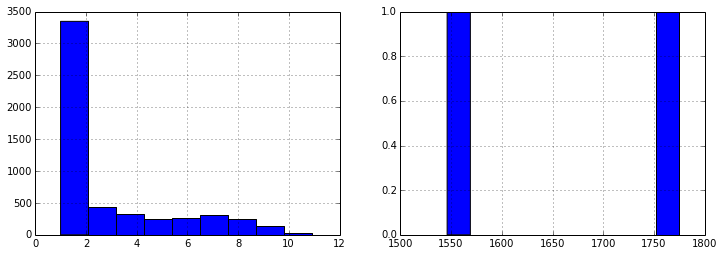

In [7]:
# plotting the time interval betwe

plt.figure() 
plt.subplot(1,2,1)
_ = df['time_diff'][df['time_diff'] < 600].hist(figsize=(12,4))
plt.subplot(1,2,2)
_ = df['time_diff'][df['time_diff'] > 600].hist(figsize=(12,4))

## Transforming the Data Set to a Time Series
In this section a new dataframs is constructed with a constant frequency of 1 second.   
In the new dataframe there is exactly 1 second between all data points.
There are no missing data points - a row is generated for every second from start to end time

In [8]:
# create a new dataframe from original dataframe with a constant frequency of one second
time_series = df.asfreq(freq='S', )
time_series.head(10)

,distance_diff,time_diff,speed_raw,moving,breaks
2015-09-13 06:25:51,0.000000,1,0.0,False,False
2015-09-13 06:25:52,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:53,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:54,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:55,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:56,23.080000,5,16.6,True,False
2015-09-13 06:25:57,6.650002,1,23.9,True,False
2015-09-13 06:25:58,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:25:59,NaN,NaN,NaN,NaN,NaN
2015-09-13 06:26:00,5.910000,3,7.1,True,False


In [9]:
time_series.moving.fillna(method = 'bfill', inplace=True)
time_series.breaks.fillna(method = 'bfill', inplace=True)
time_series.head(10)

,distance_diff,time_diff,speed_raw,moving,breaks
2015-09-13 06:25:51,0.000000,1,0.0,False,False
2015-09-13 06:25:52,NaN,NaN,NaN,True,False
2015-09-13 06:25:53,NaN,NaN,NaN,True,False
2015-09-13 06:25:54,NaN,NaN,NaN,True,False
2015-09-13 06:25:55,NaN,NaN,NaN,True,False
2015-09-13 06:25:56,23.080000,5,16.6,True,False
2015-09-13 06:25:57,6.650002,1,23.9,True,False
2015-09-13 06:25:58,NaN,NaN,NaN,True,False
2015-09-13 06:25:59,NaN,NaN,NaN,True,False
2015-09-13 06:26:00,5.910000,3,7.1,True,False


In [10]:
time_series['speed_raw_ts'] = float(0)
time_series['distance_ts'] = float(0)

In [11]:
num_rows = len( time_series[ (time_series.time_diff.notnull() )] )
for i in range( num_rows ):
    row = time_series[ (time_series.time_diff.notnull() )].iloc[i] 
    row_time = row.name
    if row.breaks == False:
        start_time = row_time - timedelta(seconds = ( int(row.time_diff) - 1))
        new_dist = ( row.distance_diff / int(row.time_diff) ) 
        time_series[ start_time:row_time ].distance_ts = new_dist
        time_series[ start_time:row_time ].speed_raw_ts = new_dist * 3.6

In [12]:
del time_series['distance_diff']
del time_series['time_diff']
time_series.head(10)

,speed_raw,moving,breaks,speed_raw_ts,distance_ts
2015-09-13 06:25:51,0.0,False,False,0.000000,0.000000
2015-09-13 06:25:52,NaN,True,False,16.617600,4.616000
2015-09-13 06:25:53,NaN,True,False,16.617600,4.616000
2015-09-13 06:25:54,NaN,True,False,16.617600,4.616000
2015-09-13 06:25:55,NaN,True,False,16.617600,4.616000
2015-09-13 06:25:56,16.6,True,False,16.617600,4.616000
2015-09-13 06:25:57,23.9,True,False,23.940005,6.650002
2015-09-13 06:25:58,NaN,True,False,7.092000,1.970000
2015-09-13 06:25:59,NaN,True,False,7.092000,1.970000
2015-09-13 06:26:00,7.1,True,False,7.092000,1.970000


## Exploring the Raw Speed Data

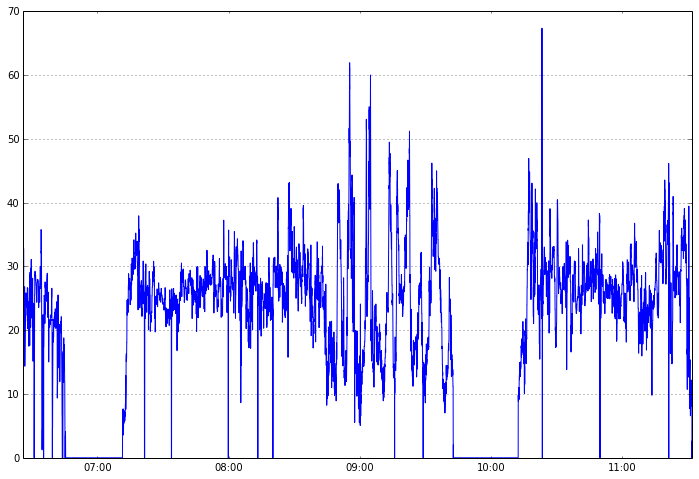

In [13]:
#Plot the speed data for all data points
_ = time_series['speed_raw_ts'].plot(figsize=(12,8),)

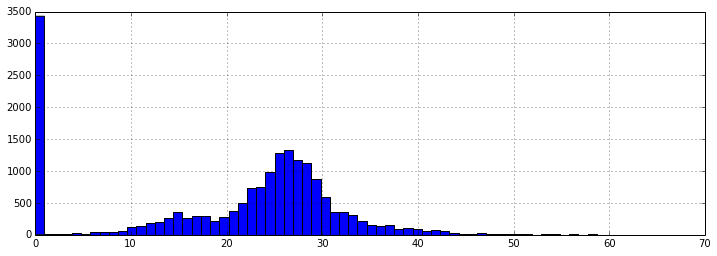

In [14]:
time_series['speed_raw_ts'].hist(bins=70,
                figsize=(12,4),)

## Exploring Maximum and Top Speeds

In [15]:
# check the data points where speed is greater than 60km/hour
# order query by speed (descending)
time_series[ time_series['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], ascending = False)

,speed_raw,moving,breaks,speed_raw_ts,distance_ts
2015-09-13 10:23:16,67.4,True,False,67.359375,18.710938
2015-09-13 08:55:19,61.9,True,False,61.945312,17.207031
2015-09-13 08:55:17,61.2,True,False,61.200000,17.000000
2015-09-13 08:55:16,60.9,True,False,60.918750,16.921875
2015-09-13 09:04:51,60.0,True,False,60.018750,16.671875


The above query shows that highest speed is recorded at 10:23:16 - only a single point around this time is greater than 60 km/hr. 

The second highest speed is at 08:55:19 - it is clearly part of a cluster of 3 points where speed is greater than 60 km/hr. 


In [16]:
# store the indexes related to max speed in variables
# index_max_speed1 holds time index for max speed
# index_max_speed2 holds time index for second highest speed

index_max_speed1, index_max_speed2 = \
            time_series[time_series['speed_raw_ts'] > 60.0].sort(columns = ['speed_raw_ts'], 
                        ascending = False).index.tolist()[:2]
    
print('The time index for the maximum speed is ' + str(index_max_speed1))
print('The time index for the second highest speed is ' + str(index_max_speed2))


The time index for the maximum speed is 2015-09-13 10:23:16
The time index for the second highest speed is 2015-09-13 08:55:19


### Working with Specific Time Windows

In [17]:
# This is a utility function needed to work with time windows
def get_window_range(dataframe, center_index, window):
    '''
    Return the index at the start and end of given time window for a specific data frame
    
    Input: 
        dataframe - name of dataframe
        center_index - time index in center of window
        window - time window, interval size in seconds
        
    Output:
        index_start - start index for time window
        index_end - end index
    
    '''
    interval = timedelta(seconds=window/2)
    index_start =  center_index - interval
    index_end = center_index + interval
    
    return index_start, index_end

### Exploring the window centred on Maximum Speed  at 10:18:14 


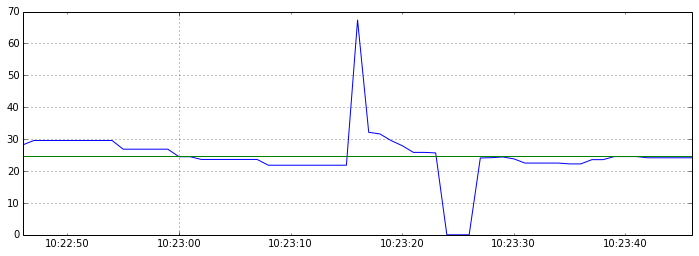

In [18]:
# Here we define the width of the time window in seconds
time_window_seconds = 60

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(time_series, index_max_speed1, time_window_seconds)

avg_speed = time_series['speed_raw_ts'][ index_start: index_end ].mean()


plt.figure();
time_series['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),)
_ = plt.axhline(avg_speed, color='g')

In [19]:
window_start_time = time_series.loc[index_start].name.strftime('%H:%M:%S')
window_end_time = time_series.loc[index_end].name.strftime('%H:%M:%S')
window_duration = ( time_series.loc[index_end].name - time_series.loc[index_start].name ).total_seconds()
max_speed = time_series['speed_raw_ts'][ index_start: index_end ].max()


print('Window starts at ' + window_start_time  + 
      ', ends at ' + window_end_time +
      ', duration is ' + str(window_duration)  + ' seconds')
print('Average Speed for this period ' + str(avg_speed) )
print('Max Speed for this period ' + str(max_speed) )

Window starts at 10:22:46, ends at 10:23:46, duration is 60.0 seconds
Average Speed for this period 24.6383809646
Max Speed for this period 67.359375


In [20]:
# check a few data points either side of maximum
time_series[ index_start : index_end ][25:35]

,speed_raw,moving,breaks,speed_raw_ts,distance_ts
2015-09-13 10:23:11,NaN,True,False,21.821484,6.061523
2015-09-13 10:23:12,NaN,True,False,21.821484,6.061523
2015-09-13 10:23:13,NaN,True,False,21.821484,6.061523
2015-09-13 10:23:14,NaN,True,False,21.821484,6.061523
2015-09-13 10:23:15,21.8,True,False,21.821484,6.061523
2015-09-13 10:23:16,67.4,True,False,67.359375,18.710938
2015-09-13 10:23:17,32.1,True,False,32.146875,8.929688
2015-09-13 10:23:18,31.6,True,False,31.640625,8.789062
2015-09-13 10:23:19,29.6,True,False,29.559375,8.210938
2015-09-13 10:23:20,28.0,True,False,27.956250,7.765625


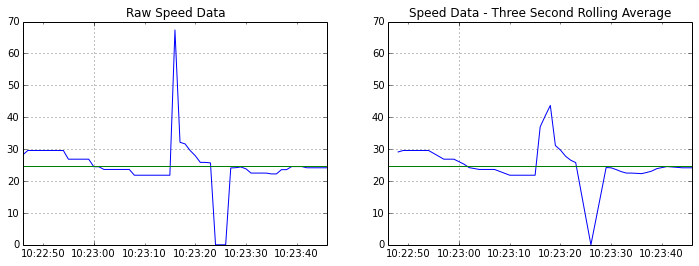

In [21]:
plt.figure() 
plt.subplot(1,2,1)
plt.ylim( (0,70) )
time_series['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( time_series[ index_start : index_end ].speed_raw_ts , 3).plot(
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

As can be seen the smoothing function has a dramatic impact on the peak speed -its reduces the maximum speed from almost 70 km/hr to about 45 km/hr.  The smoothing function provides a more realistic representation of the actual speed.

### Exploring the window centred on Second Highest Speed  at 08:55:19

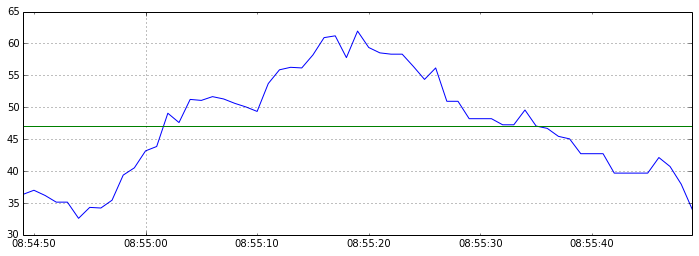

In [22]:
# Here we define the width of the time window in seconds
time_window_seconds = 60

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(time_series, index_max_speed2, time_window_seconds)

avg_speed = time_series['speed_raw_ts'][ index_start: index_end ].mean()


plt.figure();
time_series['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),)
_ = plt.axhline(avg_speed, color='g')

In [23]:
window_start_time = time_series.loc[index_start].name.strftime('%H:%M:%S')
window_end_time = time_series.loc[index_end].name.strftime('%H:%M:%S')
window_duration = ( time_series.loc[index_end].name - time_series.loc[index_start].name ).total_seconds()
max_speed = time_series['speed_raw_ts'][ index_start: index_end ].max()


print('Window starts at ' + window_start_time  + 
      ', ends at ' + window_end_time +
      ', duration is ' + str(window_duration)  + ' seconds')
print('Average Speed for this period ' + str(avg_speed) )
print('Max Speed for this period ' + str(max_speed) )

Window starts at 08:54:49, ends at 08:55:49, duration is 60.0 seconds
Average Speed for this period 47.129892418
Max Speed for this period 61.9453125


In [24]:
# check a few data points either side of maximum
time_series[ index_start : index_end ][25:35]

,speed_raw,moving,breaks,speed_raw_ts,distance_ts
2015-09-13 08:55:14,56.2,True,False,56.165625,15.601562
2015-09-13 08:55:15,58.2,True,False,58.204687,16.167969
2015-09-13 08:55:16,60.9,True,False,60.918750,16.921875
2015-09-13 08:55:17,61.2,True,False,61.200000,17.000000
2015-09-13 08:55:18,57.8,True,False,57.782812,16.050781
2015-09-13 08:55:19,61.9,True,False,61.945312,17.207031
2015-09-13 08:55:20,59.4,True,False,59.371875,16.492188
2015-09-13 08:55:21,58.5,True,False,58.528125,16.257812
2015-09-13 08:55:22,NaN,True,False,58.324219,16.201172
2015-09-13 08:55:23,58.3,True,False,58.324219,16.201172


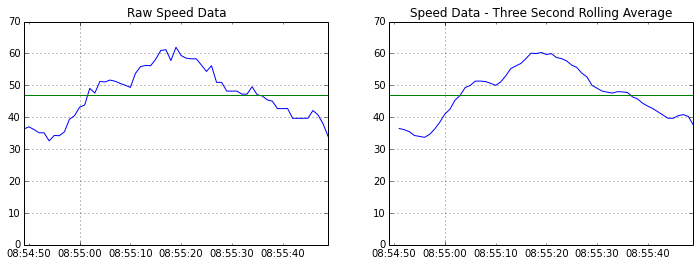

In [25]:
plt.figure() 
plt.subplot(1,2,1)
plt.ylim( (0,70) )
time_series['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( time_series[ index_start : index_end ].speed_raw_ts , 3).plot(
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

Smoothing function accurately smooths the speed data.  It makes no dramatic changes - just provides a subtle data smoothing.

## Calculate Rolling Avg Speed and Save to Time Series

In [26]:
# having experimented with different values, 
# a smoothing window size of 3 seconds appears to provide best results
window_size_seconds = 3

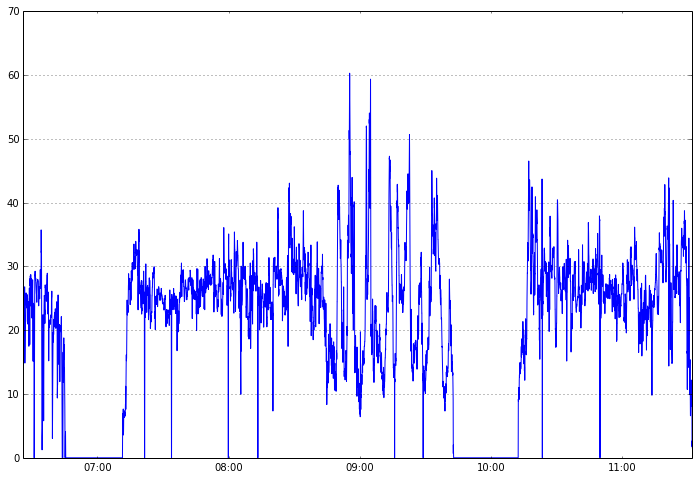

In [27]:
# graph of rolling average speed
_ = pd.rolling_mean( time_series['speed_raw_ts'] , window_size_seconds )\
                    .fillna(0.0).plot(figsize=(12,8),)

In [28]:
# Save rolling average speed to the time series data set
time_series['speed_rollavg'] = pd.rolling_mean( time_series['speed_raw_ts'] , \
                                               window_size_seconds ).fillna(0.0)

In [29]:
# view data series
time_series[ time_series['speed_rollavg'] > 58.0]\
        .sort(columns = ['speed_rollavg'], ascending = False)

,speed_raw,moving,breaks,speed_raw_ts,distance_ts,speed_rollavg
2015-09-13 08:55:19,61.9,True,False,61.945312,17.207031,60.309375
2015-09-13 08:55:17,61.2,True,False,61.200000,17.000000,60.107813
2015-09-13 08:55:18,57.8,True,False,57.782812,16.050781,59.967188
2015-09-13 08:55:21,58.5,True,False,58.528125,16.257812,59.948438
2015-09-13 08:55:20,59.4,True,False,59.371875,16.492188,59.700000
2015-09-13 09:04:52,58.9,True,False,58.935938,16.371094,59.376563
2015-09-13 08:55:22,NaN,True,False,58.324219,16.201172,58.741406
2015-09-13 08:55:16,60.9,True,False,60.918750,16.921875,58.429688
2015-09-13 08:55:23,58.3,True,False,58.324219,16.201172,58.392188
2015-09-13 09:04:53,55.6,True,False,55.617188,15.449219,58.190625


In [30]:
# run original query, checking raw speed and new rolling avg speed
time_series[ time_series['speed_raw'] > 60.0].sort(columns = ['speed_raw'], ascending = False)

,speed_raw,moving,breaks,speed_raw_ts,distance_ts,speed_rollavg
2015-09-13 10:23:16,67.4,True,False,67.359375,18.710938,37.000781
2015-09-13 08:55:19,61.9,True,False,61.945312,17.207031,60.309375
2015-09-13 08:55:17,61.2,True,False,61.200000,17.000000,60.107813
2015-09-13 08:55:16,60.9,True,False,60.918750,16.921875,58.429688
